In [1]:
# to reload local packages when debugging
%load_ext autoreload
%autoreload 2

%cd /mnt/c/Users/resha/Documents/Github/balancing_framework/

import pickle
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

def plot_metric(result_sets, metric, focused_form, title):
    plt.figure(figsize=(6, 4))  
    df = pd.DataFrame()

    for result_set in result_sets:
        set_title = result_set[0]
        set_data = result_set[1]
        means1 = np.array([ x[f'{metric}_mean']*100 for x in set_data ])
        # std1 = np.array([ x[f'{metric}_std'] for x in set_data ])
        timestamps1 = np.array([ x['last_ts'] for x in set_data ])

        # print(set_title)
        # print(f'Average Value: {np.mean(means1):.5g}, Highest Value: {np.max(means1):.5g}, Lowest Value: {np.min(means1):.5g}')
        df = pd.concat([df, pd.DataFrame({'mean_acc': np.mean(means1), 'low_acc': np.min(means1), 'high_acc': np.max(means1)}, index=[set_title])], axis=0)

        if set_title == focused_form:
            sns.lineplot(x=timestamps1, y=means1, label=set_title, linewidth=2)
        else:
            sns.lineplot(x=timestamps1, y=means1, label=set_title, linewidth=0.5)
        
        # plt.fill_between(timestamps1, means1 - std1, means1 + std1, alpha=0.3, label=f'{set_title} Std Dev')

    plt.title(title) #(f'{title}: {metric}')
    plt.xlabel('Timestamp')
    plt.ylabel(f'{metric}')
    plt.legend()

    plt.tight_layout()  # adjust the layout to fit the figure size
    # plt.show()
    
    df = df.reset_index().rename(columns={'index': 'data_form'})
    return df, plt


/mnt/c/Users/resha/Documents/Github/balancing_framework


In [9]:
cr_res['m4_daily_dataset_gluonts']

{'1165': [('original + frac_diff + first_order_diff',
   [{'accuracy_mean': nan,
     'f1_mean': nan,
     'accuracy_std': nan,
     'f1_std': nan,
     'mape_mean': 0.1263528381075178,
     'mape_std': 0.0,
     'time_training_seconds': 632.0145423207432,
     'time_test_seconds': nan,
     'model_name': 'transformer',
     'last_ts': 916},
    {'accuracy_mean': nan,
     'f1_mean': nan,
     'accuracy_std': nan,
     'f1_std': nan,
     'mape_mean': 0.25092354842594694,
     'mape_std': 0.0,
     'time_training_seconds': 154.68854597304016,
     'time_test_seconds': nan,
     'model_name': 'transformer',
     'last_ts': 1846},
    {'accuracy_mean': nan,
     'f1_mean': nan,
     'accuracy_std': nan,
     'f1_std': nan,
     'mape_mean': 0.022698696170534407,
     'mape_std': 0.0,
     'time_training_seconds': 271.10731748398393,
     'time_test_seconds': nan,
     'model_name': 'transformer',
     'last_ts': 2776},
    {'accuracy_mean': nan,
     'f1_mean': nan,
     'accuracy_std': 

,data_form,mean_acc,low_acc,high_acc,dataset,value_type
0,original + frac_diff + first_order_diff,24.125469,11.817190,35.929588,m4_daily_dataset_gluonts,adaptation
1,original + frac_diff,25.608860,11.439446,35.073474,m4_daily_dataset_gluonts,adaptation
2,original + first_order_diff,32.068468,3.925838,52.891326,m4_daily_dataset_gluonts,adaptation
3,original,25.592912,13.039986,58.545140,m4_daily_dataset_gluonts,adaptation
4,original + frac_diff + first_order_diff,20.161153,7.607456,38.745175,m4_daily_dataset_gluonts,consolidation
5,original + frac_diff,24.661513,8.053828,65.810135,m4_daily_dataset_gluonts,consolidation
6,original + first_order_diff,24.576684,3.356121,48.166915,m4_daily_dataset_gluonts,consolidation
7,original,17.197944,1.654585,34.753415,m4_daily_dataset_gluonts,consolidation


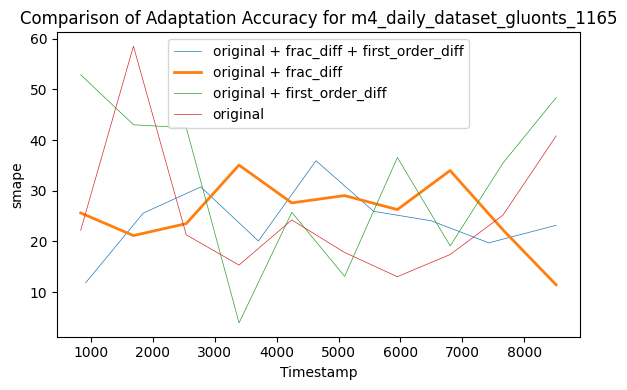

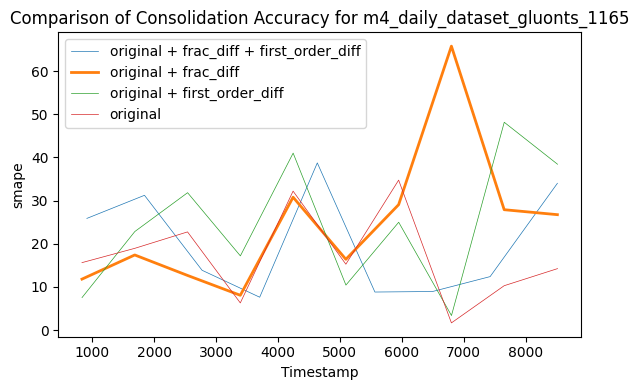

In [5]:

import os

# datasets = ['electricity', 'm4_daily_dataset', 'm4_daily_dataset_gluonts',  'london_smart_meters_without_missing', 'weather_dataset']
datasets = ['m4_daily_dataset_gluonts']
results = pd.DataFrame()
ar_res = {}
cr_res = {}
# for dataset in os.listdir('/mnt/c/Users/resha/Documents/Github/balancing_framework/results/monash_picked_single_series_runs'):
for dataset in datasets:
    res_dir = f'/mnt/c/Users/resha/Documents/Github/balancing_framework/results/monash_picked_single_series_runs/{dataset}'
    ar_res[dataset] = {}
    cr_res[dataset] = {}
    for dir in os.listdir(res_dir):
        if '.' in dir:
            continue

        series_num = dir.split('[')[0].split('_')[-2]
        if series_num not in ar_res[dataset].keys():
            ar_res[dataset][series_num] = []
            cr_res[dataset][series_num] = []

        forms_string = dir.split(']')[0].split('[')[1]
        # map form strings to print friendly
        type_map = {"'o'": 'original', "'fd'": 'frac_diff', "'fod'": 'first_order_diff'}
        forms_string = ' + '.join([type_map[abbr] for abbr in forms_string.replace(" ", "").split(",")])

        with open(f'{res_dir}/{dir}/adaptation_results.pkl', 'rb') as f:
            ar = pickle.load(f)
        with open(f'{res_dir}/{dir}/consolidation_results.pkl', 'rb') as f:
            cr = pickle.load(f)

        ar_res[dataset][series_num].append((forms_string, ar))
        cr_res[dataset][series_num].append((forms_string, cr))

sk_metric = 'accuracy'
gluonts_metric = 'smape'
focused_form = 'original + frac_diff'

for key, value in ar_res.items(): # item = dataset_name, series dict
    dataset = key
    if dataset.endswith('_gluonts'):
        metric = gluonts_metric
    else:
        metric = sk_metric
    for key, value in value.items(): # item = series_num, list of results pulled
        series_num = key
        df, plt = plot_metric(value, metric, focused_form, f'Comparison of Adaptation Accuracy for {dataset}_{series_num}')
        df['dataset'] = dataset
        df['value_type'] = 'adaptation'
        results = pd.concat([results, df], ignore_index=True)
        plt.savefig(f'{res_dir}/ada_comp_{metric}_{series_num}.png')
for key, value in cr_res.items(): # item = dataset_name, series dict
    dataset = key
    if dataset.endswith('_gluonts'):
        metric = gluonts_metric
    else:
        metric = sk_metric
    for key, value in value.items(): # item = series_num, list of results pulled
        series_num = key
        df, plt = plot_metric(value, metric, focused_form, f'Comparison of Consolidation Accuracy for {dataset}_{series_num}')
        df['dataset'] = dataset
        df['value_type'] = 'consolidation'
        results = pd.concat([results, df], ignore_index=True)
        plt.savefig(f'{res_dir}/cons_comp_{metric}_{series_num}.png')

results